# Q(1)

## Using the knowledge on blob detection, i.e., using Laplacian of Gaussians and scale-space extrema detection, we will detect and draw circles in the sunflower field image

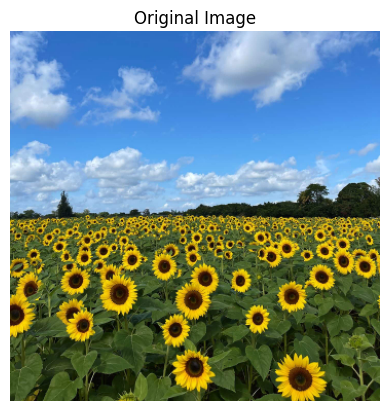

In [180]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image_input = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
image_rgb = cv.cvtColor(image_input, cv.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [181]:
# Define a custom Laplacian of Gaussian kernel
def custom_log_kernel(sigma, size):
    if size % 2 == 0:
        size += 1
    sigma2 = sigma ** 2
    indices = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_indices, y_indices = np.meshgrid(indices, indices)
    tmp_calculations = -(np.square(x_indices) + np.square(y_indices)) / (2. * sigma2)
    custom_kernel = np.exp(tmp_calculations)
    custom_kernel[custom_kernel < np.finfo(float).eps * np.amax(custom_kernel)] = 0
    custom_kernel_sum = np.sum(custom_kernel)
    if custom_kernel_sum != 0:
        custom_kernel /= np.sum(custom_kernel)
    tmp_kernel = np.multiply(custom_kernel, np.square(x_indices) + np.square(y_indices) - 2 * sigma2) / (sigma2 ** 2)
    custom_kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return custom_kernel


In [182]:
# Blob detection function
def detect_custom_blobs(input_image, scales_sigma, detection_threshold):
    gray_image = cv.cvtColor(input_image, cv.COLOR_BGR2GRAY)
    gray_image = np.float32(gray_image)
    cv.normalize(gray_image, gray_image, 1, 0, cv.NORM_MINMAX)

    sigma_initial = np.sqrt(2)
    k_factor = np.sqrt(2)
    num_scales = scales_sigma
    sigmas = sigma_initial * np.power(k_factor, np.arange(num_scales))
    sigmas = [scales_sigma] * num_scales

    # Apply LoG kernel filtering
    image_stack = None
    for i in range(num_scales):
        kernel_size = int(2 * np.ceil(4 * sigmas[i]) + 1)
        
        custom_kernel = custom_log_kernel(sigmas[i], kernel_size) * np.power(sigmas[i], 2)
        filtered_image = cv.filter2D(gray_image, cv.CV_32F, custom_kernel)
        filtered_image = np.power(filtered_image, 2)
        if i == 0:
            image_stack = filtered_image
        else:
            image_stack = np.dstack((image_stack, filtered_image))

    # Maximum response extraction
    scale_space = None
    for i in range(num_scales):
        filtered_image = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
        if i == 0:
            scale_space = filtered_image
        else:
            scale_space = np.dstack((scale_space, filtered_image))
    max_response_stack = np.amax(scale_space, axis=2)
    max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_scales, axis=2)
    max_response_stack = np.multiply((max_response_stack == scale_space), scale_space)

    x_blob_coords = None
    y_blob_coords = None
    radii_blob = None
    for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]
        threshold_value = detection_threshold
        valid_responses = (max_response_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
        valid_responses[valid_responses <= threshold_value] = 0
        (x, y) = np.nonzero(valid_responses)
        if i == 1:
            x_blob_coords = x
            y_blob_coords = y
            radii_blob = np.repeat(radius, np.size(x))
        else:
            x_blob_coords = np.concatenate((x_blob_coords, x), axis=None)
            y_blob_coords = np.concatenate((y_blob_coords, y), axis=None)
            tmp_radii = np.repeat(radius, np.size(x))
            radii_blob = np.concatenate((radii_blob, tmp_radii), axis=None)

    return x_blob_coords, y_blob_coords, radii_blob

Parameters of the largest circles-Radius:  15.556349186104047
The range of σ values:  10
sigma_values:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


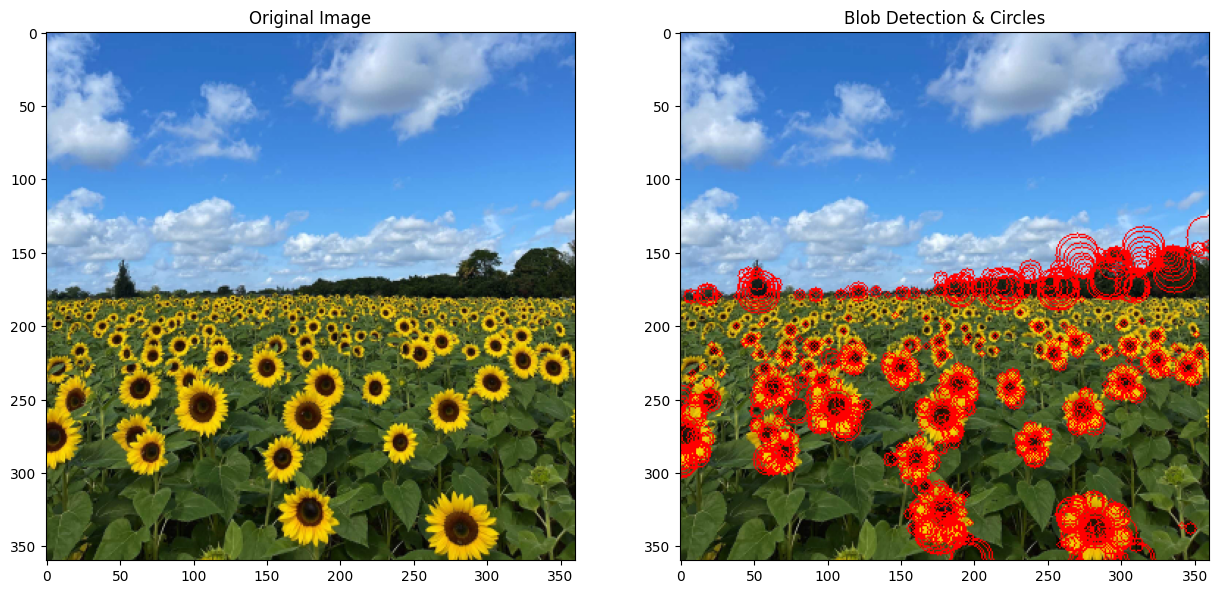

In [183]:
# Detect blobs
image_input = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
x_all_detected_blobs = []
y_all_detected_blobs = []
radii_all_detected_blobs = []
sigma_values = []
for scales_sigma_value in range(2, 12):
    x_blob_coordinates, y_blob_coordinates, radii_blob_values = detect_custom_blobs(image_input, scales_sigma_value, 0.03)
    x_all_detected_blobs.append(x_blob_coordinates)
    y_all_detected_blobs.append(y_blob_coordinates)
    radii_all_detected_blobs.append(radii_blob_values)
    sigma_values.append(scales_sigma_value)

x_all_detected_blobs = np.concatenate(x_all_detected_blobs, axis=None)
y_all_detected_blobs = np.concatenate(y_all_detected_blobs, axis=None)
radii_all_detected_blobs = np.concatenate(radii_all_detected_blobs, axis=None)
print("Parameters of the largest circles-Radius: ",np.max(radii_all_detected_blobs))
print("The range of σ values: ",len(sigma_values))
print("sigma_values: ",sigma_values)
# Draw circles
output_image = image_input.copy()
for i in range(int(len(x_all_detected_blobs))):
    cv.circle(output_image, (y_all_detected_blobs[i], x_all_detected_blobs[i]), int(radii_all_detected_blobs[i]), (0, 0, 255), 1)


fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[1].imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
ax[1].set_title("Blob Detection & Circles")
plt.show()


# Q(2)

## Generate this noisy point set X amounting to a circle and a line

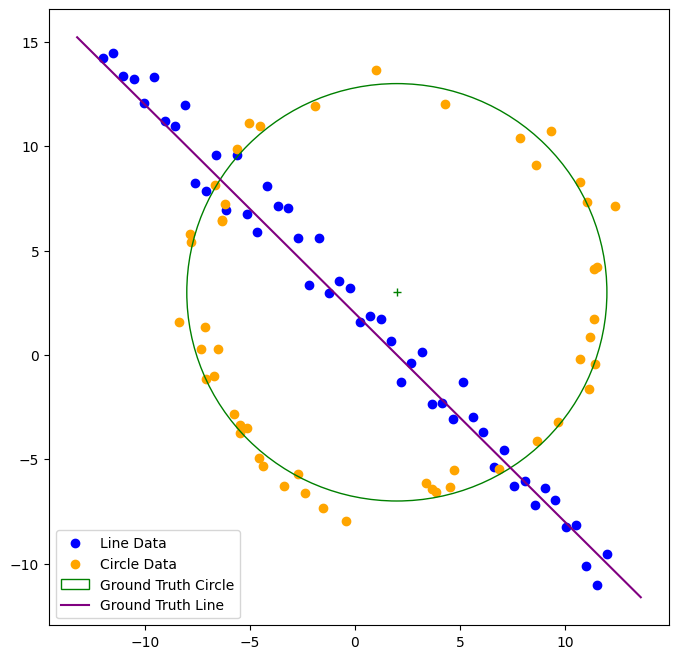

In [184]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(0)

# Number of data points
N = 100
half_n = N // 2

# Circle parameters
circle_radius = 10
circle_center_x, circle_center_y = 2, 3
circle_noise_scale = circle_radius / 16

# Generate noisy circle points
circle_angles = np.random.uniform(0, 2 * np.pi, half_n)
circle_noise = circle_noise_scale * np.random.randn(half_n)

circle_x = circle_center_x + (circle_radius + circle_noise) * np.cos(circle_angles)
circle_y = circle_center_y + (circle_radius + circle_noise) * np.sin(circle_angles)

circle_data = np.hstack((circle_x.reshape(half_n, 1), circle_y.reshape(half_n, 1)))

# Line parameters
line_slope, line_intercept = -1, 2
x_values = np.linspace(-12, 12, half_n)
y_values = line_slope * x_values + line_intercept + np.random.randn(half_n)

line_data = np.hstack((x_values.reshape(half_n, 1), y_values.reshape(half_n, 1)))

# Combine circle and line data
data = np.vstack((circle_data, line_data))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_data[:, 0], line_data[:, 1], label='Line Data', color='blue')
ax.scatter(circle_data[:, 0], circle_data[:, 1], label='Circle Data', color='orange')
ground_truth_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot((circle_center_x), (circle_center_y), '+', color='green')
x_min, x_max = ax.get_xlim()
x_values_line = np.array([x_min, x_max])
y_values_line = line_slope * x_values_line + line_intercept
plt.plot(x_values_line, y_values_line, color='purple', label='Ground Truth Line')
plt.legend()
plt.show()

## (a) Estimate the line using the RNASAC algorithm

In [185]:
# Define RANSAC for line fitting
def line_ransac(data, distance_threshold):
    S = 2
    max_iterations = 10000
    best_line = None
    best_inliers_index = []
    
    for _ in range(max_iterations):
        # Randomly select two points
        sample_indices = np.random.choice(len(data), size=S, replace=False)
        sample = data[sample_indices]
        
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        if x1 == x2:
            continue  
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init = np.abs(np.dot(unit_normal_vector, np.array([x1, y1])))
        # The perpendicular distance from the origin
        perpendicular_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in data]
        # Find the inliers
        inliers_index = [i for i, distance in enumerate(perpendicular_distances) if np.abs(distance - d_init) < distance_threshold]
        if len(inliers_index) > len(best_inliers_index):
            best_line = (unit_normal_vector, d_init)
            best_inliers_index = inliers_index
            best_fitting_points = sample
    
    return best_line, best_inliers_index, best_fitting_points

## (b) Subtract the consensus of the best line (remnant) and estimate the circle that fits the remnant using RANSAC

In [186]:
# Define circle equation
def circle_equation(params, data):
    h, k, r = params
    residuals = []
    for x, y in data:
        residuals.append((x - h)**2 + (y - k)**2 - r**2)
    return np.array(residuals)

# Define RANSAC for circle fitting
def circle_ransac(data, radial_distance_threshold):
    S = 3
    max_iterations = 10000
    best_circle = None
    best_inliers_index = []

    for _ in range(max_iterations):
        # Randomly select three points
        sample_indices = np.random.choice(len(data), size=S, replace=False)
        sample = data[sample_indices]
        # Use optimizer to get circle parameters
        result = minimize(lambda params: np.sum(circle_equation(params, sample)**2), [0, 0, 1])
        # Optimized center coordinates and radius
        h_opt, k_opt, r_opt = result.x
        # Calculate the radial distance
        radial_distances = [np.abs(np.sqrt((x - h_opt)**2 + (y - k_opt)**2) - r_opt) for x, y in data]
        # Find the inliers 
        inliers_index = [i for i, distance in enumerate(radial_distances) if distance < radial_distance_threshold]
        if len(inliers_index) > len(best_inliers_index):
            best_circle = (np.array([h_opt, k_opt]), r_opt)
            best_inliers_index = inliers_index
            best_fitting_points = sample

    return best_circle, best_inliers_index, best_fitting_points

## (c) Show all the graphs

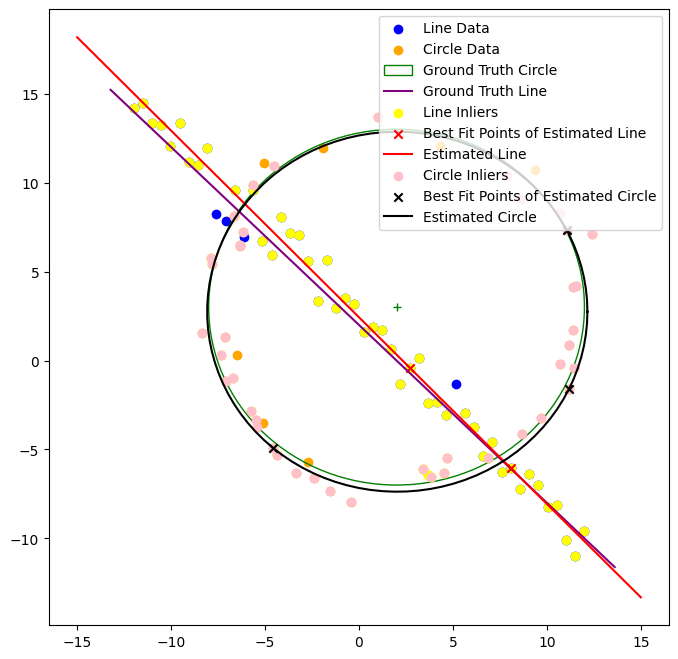

In [187]:
# Estimate the line and circle
estimated_line, inliers_index_line, best_fit_points_line = line_ransac(data, 1)
x_values_est = np.linspace(-15, 15, 100)
# Calculate the y values of the estimated line
m_est = -estimated_line[0][0] / estimated_line[0][1]
b_est = estimated_line[1] / np.cos(np.arctan(abs(m_est)))
y_values_est = m_est * x_values_est + b_est

# Estimate the circle
data_circle = data.copy()
# Remove the inliers of the line from data_circle
data_circle = np.delete(data_circle, inliers_index_line, axis=0)
estimated_circle, inliers_index_circle, best_fit_points_circle = circle_ransac(data_circle, 1)
theta = np.linspace(0, 2 * np.pi, 100)
x_values_circle_est = estimated_circle[0][0] + estimated_circle[1] * np.cos(theta)
y_values_circle_est = estimated_circle[0][1] + estimated_circle[1] * np.sin(theta)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_data[:, 0], line_data[:, 1], label='Line Data', color='blue')
ax.scatter(circle_data[:, 0], circle_data[:, 1], label='Circle Data', color='orange')
circle_gt = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot((circle_center_x), (circle_center_y), '+', color='green')
x_min, x_max = ax.get_xlim()
x_values_line_gt = np.array([x_min, x_max])
y_values_line_gt = line_slope * x_values_line_gt + line_intercept
plt.plot(x_values_line_gt, y_values_line_gt, color='purple', label='Ground Truth Line')
ax.scatter(data[inliers_index_line][:, 0], data[inliers_index_line][:, 1], color='yellow', label='Line Inliers')
ax.scatter(np.array(best_fit_points_line)[:, 0], np.array(best_fit_points_line)[:, 1], marker='x', color='red', label='Best Fit Points of Estimated Line')
ax.plot(x_values_est, y_values_est, color='red', label='Estimated Line')
ax.scatter(data[inliers_index_circle][:, 0], data[inliers_index_circle][:, 1], color='pink', label='Circle Inliers')
ax.scatter(np.array(best_fit_points_circle)[:, 0], np.array(best_fit_points_circle)[:, 1], marker='x', color='black', label='Best Fit Points of Estimated Circle')
ax.plot(x_values_circle_est, y_values_circle_est, color='black', label='Estimated Circle')
plt.legend()
plt.show()

## (d) What will happen if we fit the circle first?

If I fit the circle first, the RANSAC algorithm will prioritize finding and fitting a circular pattern in thid data. This means it will remove data points that belong to the circle as inliers and keep any potential outliers that don't fit the circular pattern. When I later try to fit a line to the remaining data points, the line estimation may be influenced by these outliers, leading to a less accurate line fit. So, the order of fitting these shapes can affect the final results, with fitting the circle first potentially impacting the accuracy of the line fit due to the presence of outliers.

# Q(3)

## Superimposed the Flag

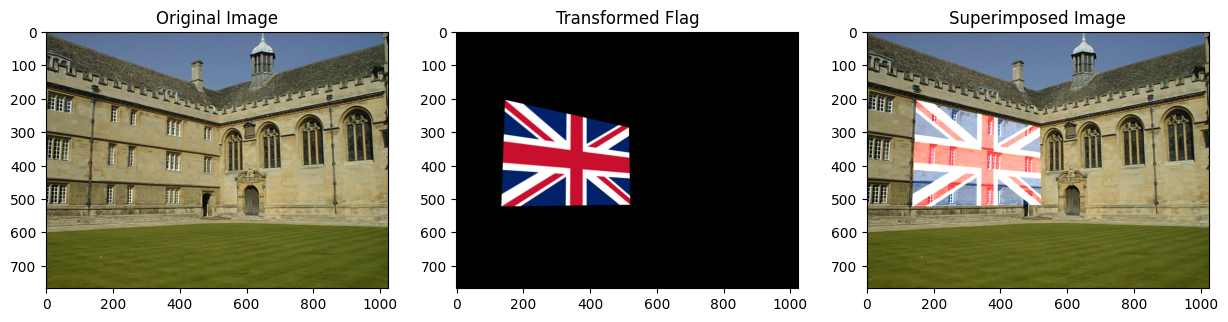

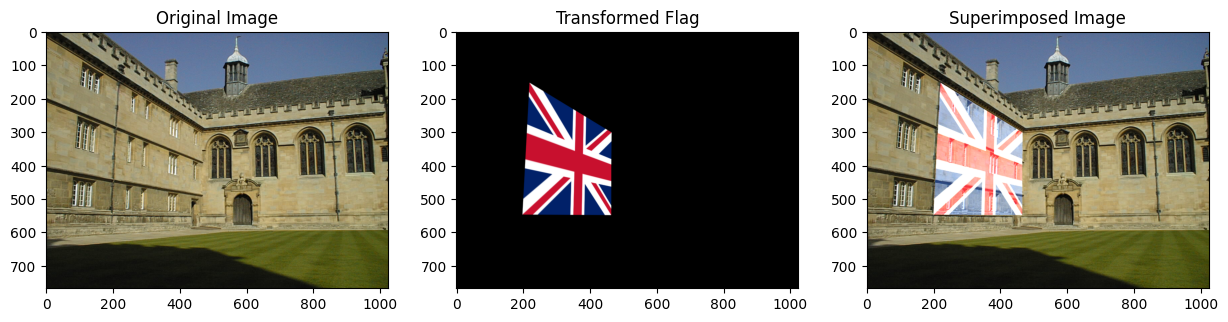

In [188]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists and variables
clicked_points = []

def mouse_click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        clicked_points.append([x, y])

image_paths = ["architectural_image1.jpg", "architectural_image2.jpg"]

for i in range(2):
    # Read the image
    input_image = cv.imread(image_paths[i])

    # Show the input image and collect clicked points
    clicked_points = []
    cv.imshow("Input Image", input_image)
    cv.setMouseCallback("Input Image", mouse_click)
    cv.waitKey(0)
    cv.destroyAllWindows()

    # Get image dimensions
    image_height, image_width = np.shape(input_image)[0], np.shape(input_image)[1]

    # Define a zero matrix
    zero_matrix = np.array([[0], [0], [0]])

    # Extract clicked points
    x1, y1, x2, y2, x3, y3, x4, y4 = (
        clicked_points[0][0],
        clicked_points[0][1],
        clicked_points[1][0],
        clicked_points[1][1],
        clicked_points[2][0],
        clicked_points[2][1],
        clicked_points[3][0],
        clicked_points[3][1],
    )

    flag_image = cv.imread("flag_image.jpg")
    flag_height, flag_width = np.shape(flag_image)[0], np.shape(flag_image)[1]

    # Define corner points of the flag image
    f1, f2, f3, f4 = np.array([[0, 0, 1]]), np.array([[flag_width - 1, 0, 1]]), np.array(
        [[flag_width - 1, flag_height - 1, 1]]
    ), np.array([[0, flag_height - 1, 1]])

    # Construct matrix A
    matrix_A = np.concatenate(
        (
            np.concatenate((zero_matrix.T, f1, -y1 * f1), axis=1),
            np.concatenate((f1, zero_matrix.T, -x1 * f1), axis=1),
            np.concatenate((zero_matrix.T, f2, -y2 * f2), axis=1),
            np.concatenate((f2, zero_matrix.T, -x2 * f2), axis=1),
            np.concatenate((zero_matrix.T, f3, -y3 * f3), axis=1),
            np.concatenate((f3, zero_matrix.T, -x3 * f3), axis=1),
            np.concatenate((zero_matrix.T, f4, -y4 * f4), axis=1),
            np.concatenate((f4, zero_matrix.T, -x4 * f4), axis=1),
        ),
        axis=0,
        dtype=np.float64,
    )

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(matrix_A.T, matrix_A))

    # Find the eigenvector corresponding to the minimum eigenvalue
    min_eigenvector = eigenvectors[:, np.argmin(eigenvalues)]

    # Reshape the eigenvector to obtain the homography matrix
    homography_matrix = min_eigenvector.reshape((3, 3))

    # Warp the flag image onto the input image using the homography matrix
    transformed_flag = cv.warpPerspective(flag_image, homography_matrix, (image_width, image_height))

    # Combine the transformed flag and the input image
    superimposed_image = cv.add(transformed_flag, input_image)

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(cv.cvtColor(input_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[1].imshow(cv.cvtColor(transformed_flag, cv.COLOR_BGR2RGB))
    ax[1].set_title("Transformed Flag")
    ax[2].imshow(cv.cvtColor(superimposed_image, cv.COLOR_BGR2RGB))
    ax[2].set_title("Superimposed Image")
    plt.show()


## You may explain the (non-technical) rationale of your choice.

To superimpose a flag onto an architectural image, first, select a pair of images: the architectural background and the flag image. Display the architectural image and collect four user-selected points on the planar surface of interest. Calculate a homography matrix using these points, then load and prepare the flag image with its corner points defined. Finally, apply the homography transformation to warp the flag image onto the architectural image and blend them together, resulting in a superimposed image. Repeat this process for multiple image pairs of the choice to achieve the desired effect.

# Q(4)

## (a) Compute and match SIFT features between the two images

((< cv2.DMatch 0000020B8D185470>, < cv2.DMatch 0000020BECF95330>), (< cv2.DMatch 0000020B90BAEC30>, < cv2.DMatch 0000020B933405F0>), (< cv2.DMatch 0000020B93340310>, < cv2.DMatch 0000020B8D6E9170>), (< cv2.DMatch 0000020B8D6E9370>, < cv2.DMatch 0000020B8D6E92D0>), (< cv2.DMatch 0000020B8C893270>, < cv2.DMatch 0000020B8D7E4C70>))


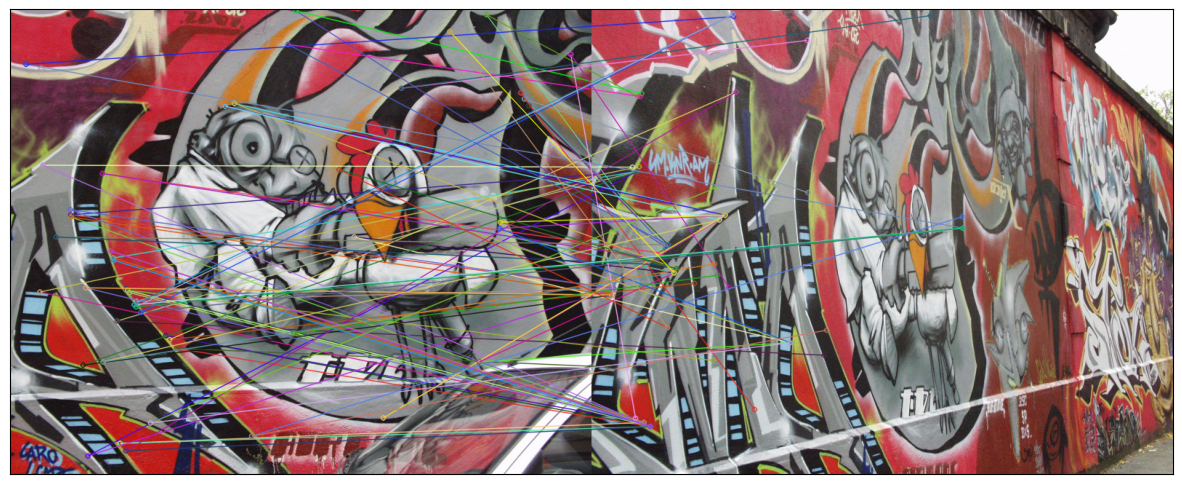

In [189]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image1 = cv.imread('img1.ppm')
image5 = cv.imread('img5.ppm')

image1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
image5_gray = cv.cvtColor(image5, cv.COLOR_BGR2GRAY)
image1_rgb = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image5_rgb = cv.cvtColor(image5, cv.COLOR_BGR2RGB)

# Create SIFT and Brute Force Matcher objects
sift = cv.SIFT_create()
bf_matcher = cv.BFMatcher()

# Detect and compute keypoints and descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(image5_gray, None)

# Match keypoints using Brute Force Matcher
matches = bf_matcher.knnMatch(descriptors1, descriptors5, k=2)
print(matches[:5])

# Sort matches by distance
matches = sorted(matches, key=lambda x: x[0].distance)

# Draw the top 50 matches
output_image = cv.drawMatchesKnn(image1_rgb, keypoints1, image5_rgb, keypoints5, matches[:50], image5_rgb, flags=2)

figure, axis = plt.subplots(figsize=(15, 15))
axis.imshow(output_image)
axis.set_xticks([])
axis.set_yticks([])

plt.show()


In [190]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def find_features(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def find_matches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches

## (b) Compute the homography using your own code within RANSAC and compare with the homography given in the dataset

In [191]:
def calculate_homography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    return H

def calculate_distance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimate_p2 = np.dot(H, p1)
    estimate_p2 = (1 / estimate_p2.item(2)) * estimate_p2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimate_p2
    return np.linalg.norm(error)

def RANSAC(correspondences, threshold):
    max_inliers = []
    best_homography = []

    for i in range(int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5)**4))):
        corr1 = correspondences[np.random.randint(0, len(correspondences))]
        corr2 = correspondences[np.random.randint(0, len(correspondences))]
        sample = np.vstack((corr1, corr2))
        corr3 = correspondences[np.random.randint(0, len(correspondences))]
        sample = np.vstack((sample, corr3))
        corr4 = correspondences[np.random.randint(0, len(correspondences))]
        sample = np.vstack((sample, corr4))

        homography = calculate_homography(sample)
        inliers = []

        for j in range(len(correspondences)):
            distance = calculate_distance(homography, correspondences[j])
            if distance < threshold:
                inliers.append(correspondences[j])

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_homography = homography

    return best_homography, max_inliers

image1 = cv.imread('img1.ppm')
image5 = cv.imread('img5.ppm')
estimated_threshold = 100

# Extract features and find matches
correspondences = []
keypoints1, descriptors1 = find_features(image1)
keypoints5, descriptors5 = find_features(image5)
keypoints_list = [keypoints1, keypoints5]
matches = find_matches(descriptors1, descriptors5)

for match in matches:
    (x1, y1) = keypoints_list[0][match[0].queryIdx].pt
    (x2, y2) = keypoints_list[1][match[0].trainIdx].pt
    correspondences.append([x1, y1, x2, y2])

correspondences_matrix = np.matrix(correspondences)
homography, inliers = RANSAC(correspondences_matrix, estimated_threshold)

print("Estimated Homography Matrix:")
print(homography)
print('Number of inliers:', len(inliers))

# Load the original homography matrix from 'H1to5p' file
original_homography_matrix = []
with open('H1to5p', 'r') as h_text:
    for line in h_text:
        line = line.strip()
        line = line.split()
        line = [float(i) for i in line]
        original_homography_matrix.append(line)

original_homography_matrix = np.matrix(original_homography_matrix)
print("Provided Homography Matrix:")
print(original_homography_matrix)

Estimated Homography Matrix:
[[-8.86803801e-03 -3.71942427e-01  2.07339225e+02]
 [-1.27261996e-02 -6.72171568e-01  3.59910015e+02]
 [-9.95794514e-05 -1.82255171e-03  1.00000000e+00]]
Number of inliers: 249
Provided Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


## (c) Stitch img1.ppm onto img5.ppm

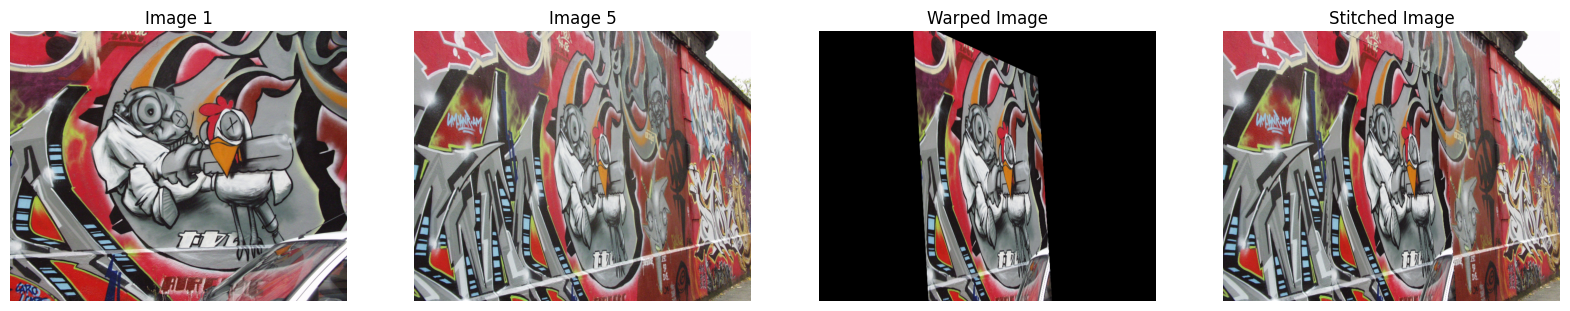

In [192]:
# Warp the first image using the estimated homography
warped_image = cv.warpPerspective(image1, original_homography_matrix, (image5.shape[1], image5.shape[0]))

# Create a mask for blending
threshold, mask = cv.threshold(cv.cvtColor(warped_image, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)

# Apply blending
image5_bg = cv.bitwise_and(image5, image5, mask=mask_inv)
blended_image = cv.addWeighted(image5_bg, 1, warped_image, 1, 0)
fig, ax = plt.subplots(1,4,figsize=(20,20))
# Display images
plt.subplot(1, 4, 1)
plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(cv.cvtColor(image5, cv.COLOR_BGR2RGB))
plt.title('Image 5')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.axis('off')

plt.show()

Feature matching and image stitching are performed between two input images, 'img1.ppm' and 'img5.ppm.' Initially, SIFT (Scale-Invariant Feature Transform) features are extracted and matched using a Brute Force Matcher. Then, a RANSAC-based method is used to estimate a homography matrix that transforms points from the first image to the second image. The estimated homography matrix is compared to a provided ground truth homography matrix ('H1to5p'). Finally, the first image is warped using the estimated homography, and a blending technique is applied to create a stitched image, which is displayed alongside the original images. The estimated homography matrix appears to be close to the provided one, indicating a successful alignment of the images.